# Getting started: Skeleton analysis with Skan

Skeleton analysis allows us to measure fine structure in samples. In this case, we are going to measure the network formed by a protein called *spectrin* inside the membrane of a red blood cell, either infected by the malaria parasite *Plasmodium falciparum*, or uninfected.

## 0. Extracting a skeleton from an image

Skan's primary purpose is to analyse skeletons. (It primarily mimics the ["Analyze Skeleton" Fiji plugin](https://imagej.net/AnalyzeSkeleton).) In this section, we will run some simple preprocessing on our source images to extract a skeleton, provided by Skan and [scikit-image](https://scikit-image.org), but this is far from the optimal way of extracting a skeleton from an image. Skip to section 1 for Skan's primary functionality.

First, we load the images. These images were produced by an FEI scanning electron microscope. [ImageIO](https://imageio.github.io) provides a method to read these images, including metadata.

In [9]:
from glob import glob
import imageio as iio

files = glob('example-data/*.tif')
image0 = iio.imread(files[0], format='fei')

We display the images with [Matplotlib](http://matplotlib.org).

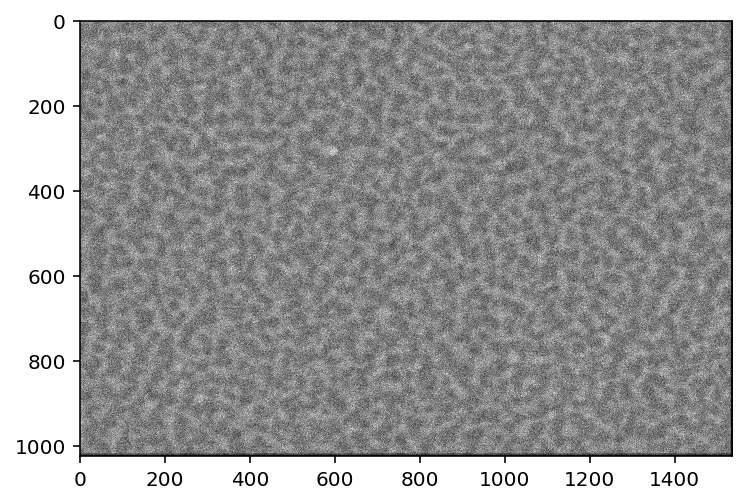

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots()
ax.imshow(image0, cmap='gray');

As an aside, we can extract the pixel spacing in meters from the `.meta` attribute of the ImageIO image:

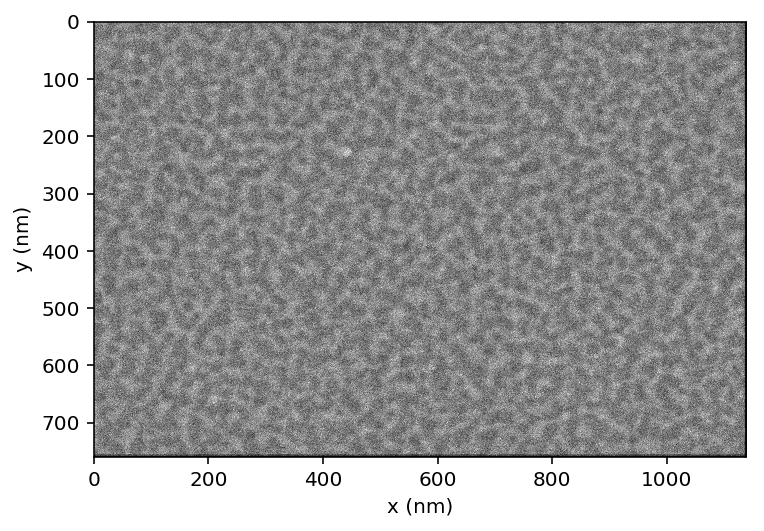

In [11]:
spacing = image0.meta['Scan']['PixelHeight']
spacing_nm = spacing * 1e9  # nm per pixel
dim_nm = np.array(im0.shape) / spacing_nm

fig, ax = plt.subplots()
ax.imshow(image0, cmap='gray',
          extent=[0, dim_nm[1], dim_nm[0], 0]);
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)');

This is an image of the inside of the membrane of a red blood cell. We want to measure the network of bright regions in this image, which is made up of a protein called *spectrin*. Our strategy will be to:

- smooth the image with Gaussian smoothing
- threshold the image with Sauvola thresholding (Otsu thresholding also works)
- skeletonise the resulting binary image

These steps can be performed by a single function in Skan, `skan.pre.threshold`. We use parameters derived from the metadata, so that our analysis is portable to images taken at slightly different physical resolutions.

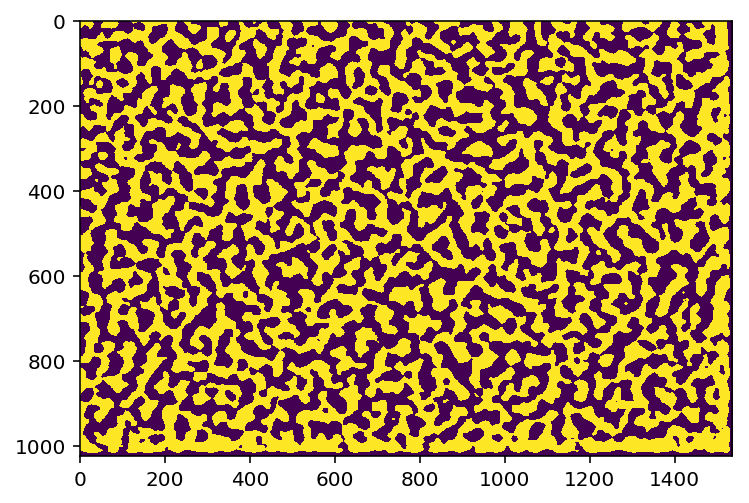

In [12]:
from skan.pre import threshold

smooth_radius = 5 / spacing_nm  # float OK
threshold_radius = int(np.ceil(50 / spacing_nm))
binary0 = threshold(image0, sigma=smooth_radius,
                    radius=threshold_radius)

fig, ax = plt.subplots()
ax.imshow(binary0);

(There are some thresholding artifacts around the edges, due to the dark border caused by microscope imaging drift and alignment. We will ignore this in this document, but the Skan GUI allows for a "crop" parameter to filter out these regions.)

Finally, we skeletonise this binary image:

In [15]:
from skimage import morphology

skeleton0 = morphology.skeletonize(binary0)

Skan has functions for drawing 2D skeletons in 2D:

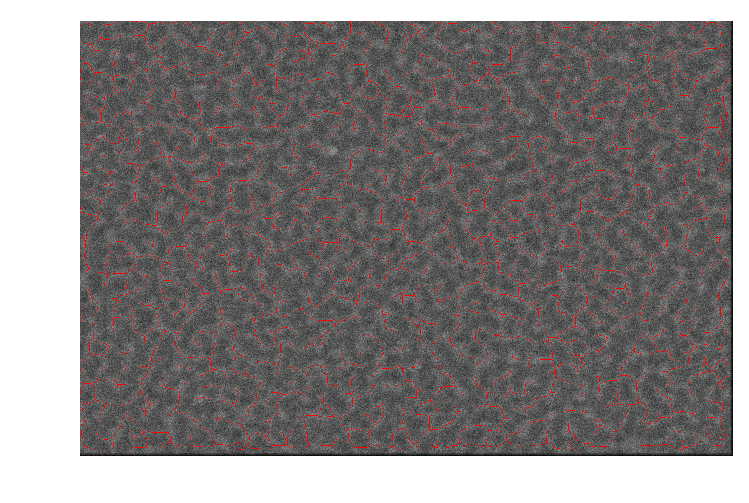

In [17]:
from skan import draw

fig, ax = plt.subplots()
draw.overlay_skeleton_2d(image0, skeleton0, axes=ax);